In [2]:
import pandas as pd
# import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pymongo

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Useful Variables

In [4]:
EMISSIONS_TO_DATE = 500000000000
ONEFIVE_DEG_CARBON_BUDGET_KG = 1000000000000000
TWO_DEG_CARBON_BUDGET_KG = 1330000000000000
TWOFIVE_DEG_CARBON_BUDGET_KG = 1500000000000000
DEGR_PER_TON_CARBON = 0.0000000000015
CURRENT_POPULATION = 7400000000
YEARS_TO_2100 = 84
YEARS_TO_2050 = 34
GIGATON = 1000000000000

### Chart Style Settings

In [6]:
sns.set_style('whitegrid')
sns.despine();

In [7]:
def remove_gridlines(ax):
    ax.yaxis.grid(False)
    ax.xaxis.grid(False)

In [8]:
def modify_gridlines(ax):    
    for line in ax.get_ygridlines():
        line.set_linestyle(':')

    for line in ax.get_xgridlines():
        line.set_linestyle(':')

### Read in the Data

#### Transportation Carbon

In [9]:
client = pymongo.MongoClient('localhost', 27017)
db = client.carbon

In [10]:
transports = list(db.moves2.find())

In [11]:
tdf = pd.DataFrame(transports)
tdf['date'] = tdf.startDatetime.apply(pd.to_datetime)
tdf.index = tdf.startDatetime
tdf.sort_index(inplace=True)
tdf['cumulative'] = tdf.carbon.cumsum()

#### Electricity Carbon

In [12]:
electricity = pd.read_csv('../data/green_button.csv')
electricity.columns=['time_period', 'usage_kwh', 'cost']

In [13]:
electricity['time_period'] = electricity.time_period.apply(lambda d: d.split(' - '))

In [26]:
electricity['start_date'] = electricity.time_period.apply(lambda t: t[0])
electricity['end_date'] = electricity.time_period.apply(lambda t: t[1])

In [27]:
electricity['date_range'] = electricity.time_period.apply(
    lambda d: pd.date_range(d[0], d[1]))

In [28]:
from __future__ import division

In [29]:
def create_series(row):
    avg_usage = [row['usage_kwh'] / row['date_range'].shape[0]]
    period_length = row['date_range'].shape[0]
    usage = avg_usage * period_length
    return pd.Series(usage, index=row['date_range']).sort_index(ascending=False)
    
# pd.Series([row['usage_kwh']] * len(list(row['date_range'])), index=row['date_range']

In [30]:
# electricity['usage_ranges'] = electricity.apply(create_series, 1)
series = [create_series(row) for row in electricity.to_dict(orient='records')]
edf = pd.concat(series).reset_index()
edf.columns = ['date', 'usage_kwh']
edf['date'] = edf.date.apply(pd.to_datetime)
edf.index = edf.date
edf['type'] = 'electricity'

In [39]:
edf['carbon'] = edf.usage_kwh.apply(compute_carbon_kg)

In [18]:
import requests

In [19]:
KEY = '20f32c9fad4aebc9998f8ce569bdc358'
BASE = 'http://impact.brighterplanet.com/'

In [20]:
def compute_carbon_kg(kwh):
    """ Computes the kgs of carbon for kwhours """
    url = BASE + 'electricity_uses.json'
    params = {
        'energy': kwh * 3.6,
        'zip_code': '10023',
        'key': KEY
    }
    res = requests.get(url, params=params).json()
    kgs = res['decisions']['carbon']['object']['value']

    return kgs

In [40]:
test_edf = pd.DataFrame(date_range, columns=['date'])
test_edf['date'] = test_edf.date.apply(lambda d: d.strftime('%Y-%m-%d'))
test_edf.index = test_edf.date

In [41]:
merged = test_edf.join(edf, rsuffix='_y')
merged = merged.drop('date_y', 1)

In [42]:
merged.carbon.fillna(merged.carbon.mean(), inplace=True)
merged.usage_kwh.fillna(merged.usage_kwh.mean(), inplace=True)
merged.type.fillna('electricity', inplace=True)
merged['date'] = merged.date.apply(pd.to_datetime)
merged.index = merged.date
merged.sort_index(inplace=True)
edf = merged

#### Government Carbon

In [43]:
start_date = tdf.sort_values('startDatetime').startDatetime.iloc[0]
end_date = tdf.sort_values('startDatetime').startDatetime.iloc[-1]

In [44]:
date_range = pd.date_range(start_date, end_date)

In [45]:
GOV_CARBON_KGS = 121300000000
US_POP = 322000000
PERSONAL_DAY_GOV_CARBON = GOV_CARBON_KGS / US_POP / 365

In [46]:
gdf = pd.DataFrame(date_range)
gdf['carbon'] = PERSONAL_DAY_GOV_CARBON
gdf.columns = ['date', 'carbon']
gdf['type'] = 'government'

In [47]:
df = pd.concat([
        tdf[['date', 'carbon', 'type']],
        edf[['date', 'carbon', 'type']],
        gdf
    ])

In [48]:
df.index = df.date
df.sort_index(inplace=True)

In [669]:
# Lifetime cummulative carbon footprint
# ax = plt.axes()
# tdf.cumulative.plot(figsize=(18,5))
# plt.xlabel('Date')
# plt.ylabel('Total Carbon (kg)')
# plt.title('All-time Cumulative Transportation Carbon Footprint')
# ax.yaxis.grid(False)
# for row in tdf.to_dict(orient='records'):
#     if row['type'] == 'airplane':
#         plt.axvline(row['startDatetime'], color='orange', linewidth=.5)
# orange = mpatches.Patch(color='orange', label='Flights')
# plt.legend(handles=[orange])
# plt.show()
# pylab.savefig('../images/all_time_footprint.png')

In [707]:
grouped = df[df.date >= '2014-01-01'].groupby(lambda d: d.year)

In [671]:
# tdf.groupby('type').agg('count')
# tdf.groupby([lambda d: d.year, 'type']).agg('count')

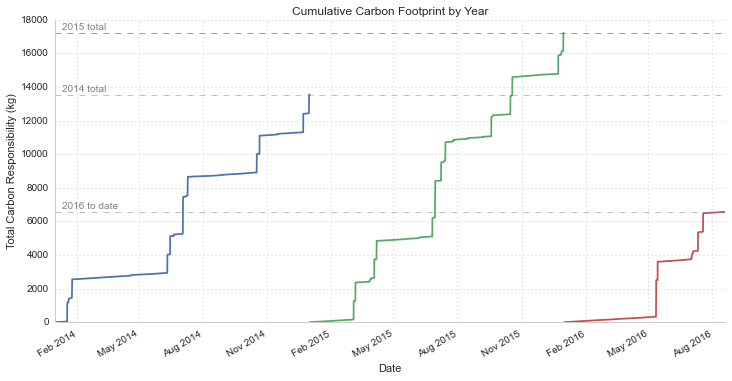

In [740]:
# Cumulative carbon footprint by year
text_x = datetime.date(2014, 1, 10)
fourteen_y = grouped.get_group(2014).carbon.sum()
fifteen_y = grouped.get_group(2015).carbon.sum()
sixteen_y = grouped.get_group(2016).carbon.sum()

ax = plt.axes()
sns.despine()
modify_gridlines(ax)

for name, group in grouped:
    group.carbon.cumsum().plot(figsize=(12,6))
plt.title('Cumulative Carbon Footprint by Year')
plt.xlabel('Date')
plt.ylabel('Total Carbon Responsibility (kg)')

plt.axhline(fourteen_y, color='gray', linewidth=.5, linestyle='--')
plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')

ax.text(text_x, fourteen_y + 200, '2014 total', fontsize=10, color='gray')
ax.text(text_x, fifteen_y + 200, '2015 total', fontsize=10, color='gray')
ax.text(text_x, sixteen_y + 200, '2016 to date', fontsize=10, color='gray')
plt.axhline(sixteen_y, color='gray', linewidth=.5, linestyle='--')

# ax.yaxis.grid(False)
# ax.xaxis.grid(False)
    
pylab.savefig('../images/cumulative_footprint_by_year.png')

In [708]:
grouped_wo_flights = df[
    (df.type != 'airplane') &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [715]:
grouped_wo_cars = df[
    (~df.type.isin(['car', 'airplane'])) &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [718]:
grouped_wo_govt = df[
    (~df.type.isin(['car', 'airplane', 'government'])) &
    (df.date >= '2014-01-01')
].groupby(lambda d: d.year)

In [712]:
grouped_type = df.groupby('type')

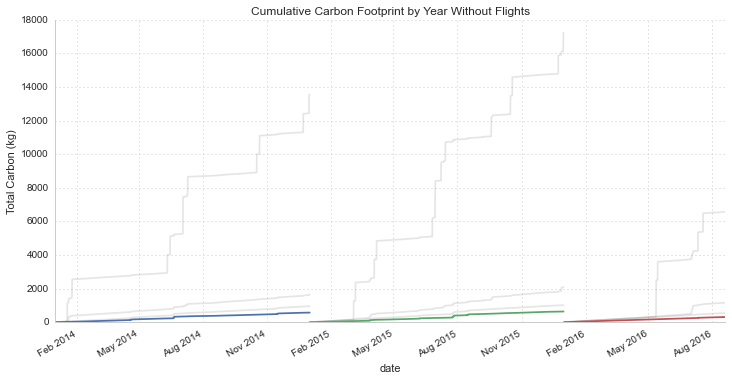

In [739]:
text_x = datetime.date(2014, 1, 10)
fourteen_y = grouped_wo_flights.get_group(2014).carbon.sum()
fifteen_y = grouped_wo_flights.get_group(2015).carbon.sum()
sixteen_y = grouped_wo_flights.get_group(2016).carbon.sum()

ax = plt.axes()
sns.despine()
modify_gridlines(ax)
# pylab.ylim([0,18000])

for name, group in grouped:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')

for name, group in grouped_wo_flights:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')
    
for name, group in grouped_wo_cars:
    group.carbon.cumsum().plot(figsize=(12,6), alpha=0.2, color='gray')
    
for name, group in grouped_wo_govt:
    group.carbon.cumsum().plot(figsize=(12,6), )    
    
plt.title('Cumulative Carbon Footprint by Year Without Flights')
plt.ylabel('Total Carbon (kg)')
# plt.xlabel('Date')

# plt.axhline(fourteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, fourteen_y + 200, '2014 total', fontsize=10, color='gray')
# plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, fifteen_y + 200, '2015 total', fontsize=10, color='gray')
# plt.axhline(fifteen_y, color='gray', linewidth=.5, linestyle='--')
# ax.text(text_x, sixteen_y + 200, '2016 to date', fontsize=10, color='gray')
# plt.axhline(sixteen_y, color='gray', linewidth=.5, linestyle='--')

pylab.savefig('../images/cumulative_footprint_by_year_wo_flights.png')

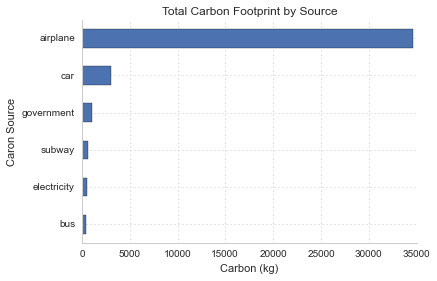

In [724]:
# Carbon distribution by transportation type
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

grouped_type.carbon.agg('sum').sort_values().plot(kind='barh')

# plt.axhline(200, color='red', linewidth=.5)
# plt.axhline(328, color='purple', linewidth=.5)
# plt.axhline(457, color='orange', linewidth=.5)

plt.title('Total Carbon Footprint by Source')
plt.xlabel('Carbon (kg)')
plt.ylabel('Caron Source')
# pylab.savefig('../images/total_footprint_by_type.png')

In [726]:
# Carbon distribution by transportation type
# ax = plt.axes()
# sns.despine()
# modify_gridlines(ax)

# grouped_type.carbon.agg('mean').sort_values().plot(kind='barh')
# plt.title('Average Carbon Per Trip by Source')
# plt.xlabel('Carbon (kg)')
# plt.ylabel('Transportation Type')

# pylab.savefig('../images/avg_footprint_by_type.png')

In [18]:
# tdf[tdf.type != 'airplane'].groupby('type').carbon.agg('sum').sort_values(ascending=False).plot(kind='bar')
# plt.axhline(200, color='red', linewidth=.5)
# plt.axhline(328, color='purple', linewidth=.5)
# plt.axhline(457, color='orange', linewidth=.5)
# plt.title('Total Carbon Footprint by Transportation Type (excluding air travel)')
# plt.xlabel('Transportation Type')
# plt.ylabel('Total Carbon (kg)')

# Where Should I Be?  What goal should I set for my carbon responsibility?

In [19]:
# degrees_per_ton = 0.0000000000015
# population = 7400000000
# years = 34
# tons = np.arange(25)

# temp_change = tons * degrees_per_ton * years * population
# twenty_fifteen_tons = grouped.get_group(2015).carbon.sum() / 1000
# personal_temp_change = twenty_fifteen_tons * degrees_per_ton * years * population
# target_tons = 2 / (degrees_per_ton * years * population)

In [20]:
x = np.arange(7)
y = x * 1.5

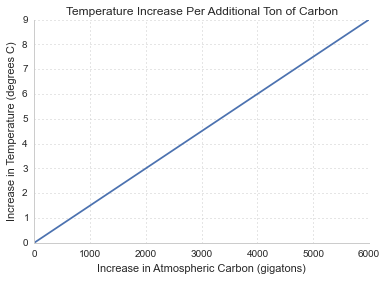

In [85]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.plot(x * 1000, y)
plt.title('Temperature Increase Per Additional Ton of Carbon')
plt.xlabel('Increase in Atmospheric Carbon (gigatons)')
plt.ylabel('Increase in Temperature (degrees C)')

pylab.savefig('../images/temp_increase_per_ton.png')

In [22]:
avg_annual_footprint_tons = ((grouped.get_group(2015).carbon.sum() + grouped.get_group(2014).carbon.sum()) / 2) / 1000

In [24]:
generalized_annual_footprint_tons = avg_annual_footprint_tons * CURRENT_POPULATION

In [25]:
generalized_annual_gigatons = generalized_annual_footprint_tons / GIGATON

In [26]:
generalized_warming = generalized_annual_footprint_tons * DEGR_PER_TON_CARBON * YEARS_TO_2050

In [27]:
generalized_tons = generalized_annual_gigatons * YEARS_TO_2050 * 1000

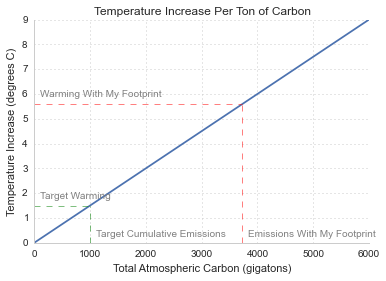

In [28]:
# Temperature increase if personal footprint was generalized
# Todo: these numbers are f'd!
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.plot(x * 1000, y)

plt.title('Temperature Increase Per Ton of Carbon')
plt.xlabel('Increase in Atmospheric Carbon (gigatons)')
plt.ylabel('Increase in Temperature (degrees C)')

plt.plot(
    [0, generalized_tons], 
    [generalized_warming, generalized_warming],
    color='red', 
    linestyle='--',
    linewidth=.5)
plt.plot(
    [generalized_tons, generalized_tons], 
    [0, generalized_warming], 
    color='red', 
    linestyle='--',
    linewidth=.5)
plt.plot([0, 1000], [1.5, 1.5], color='green', linestyle='--', linewidth=.5)
plt.plot([1000, 1000], [0, 1.5], color='green', linestyle='--', linewidth=.5)

ax.text(100, generalized_warming + .3, 'Warming With My Footprint', fontsize=10, color='gray')
ax.text(100, 1.8, 'Target Warming', fontsize=10, color='gray')
ax.text(generalized_tons + 100, .25, 'Emissions With My Footprint', fontsize=10, color='gray')
ax.text(1100, .25, 'Target Cumulative Emissions', fontsize=10, color='gray')

pylab.savefig('../images/temp_increase_with_targets.png')

In [29]:
# Temperature increase if personal footprint was generalized
# Todo: these numbers are f'd!
# ax = plt.axes()
# sns.despine()
# modify_gridlines(ax)

# plt.plot(tons, temp_change)
# plt.title('Temperature Increase Per Ton of Carbon')
# plt.xlabel('Personal Carbon Footprint (metric tons)')
# plt.ylabel('Temperature Increase (degrees C)')
# plt.plot(
#     [0, twenty_fifteen_tons], 
#     [personal_temp_change, personal_temp_change], 
#     color='red', 
#     linestyle='--',
#     linewidth=.5)
# plt.plot(
#     [twenty_fifteen_tons, twenty_fifteen_tons], 
#     [0, personal_temp_change], 
#     color='red', 
#     linestyle='--',
#     linewidth=.5)
# plt.plot([0, target_tons], [2, 2], color='green', linestyle='--', linewidth=.5)
# plt.plot([target_tons, target_tons], [0, 2], color='green', linestyle='--', linewidth=.5)
# pylab.savefig('../images/temp_increase_with_targets.png')

- [Carbon Targets - Your Footprint](http://shrinkthatfootprint.com/carbon-targets-for-your-footprint)

### Personal Carbon Quota

In [30]:
pop = pd.read_csv('../data/Kremer_CSV_WorldPop_MillionYears.csv')

In [31]:
pop_estimate = pop[(pop.year >= 2010) & (pop.year <= 2050)][
    ['year', 'World Population 1950-2013 (US Census)', 
     'UN Projection (Medium) - 2012 Revision']]

In [32]:
vals = pop_estimate.max(axis=1) * 1000000
vals.index = pop_estimate.year

### Overall Quota

In [33]:
# World Population Data: https://esa.un.org/unpd/wpp/

In [34]:
# onefivedeg = 500000000000000
# twodeg = 833000000000000

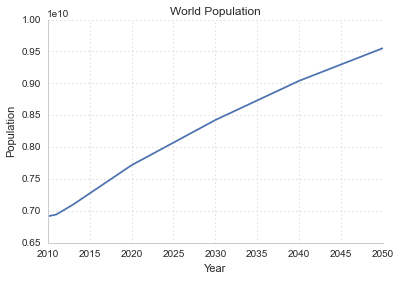

In [35]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

vals.plot()
plt.title('World Population')
plt.ylabel('Population')
plt.xlabel('Year')

In [83]:
# onefive[2013]

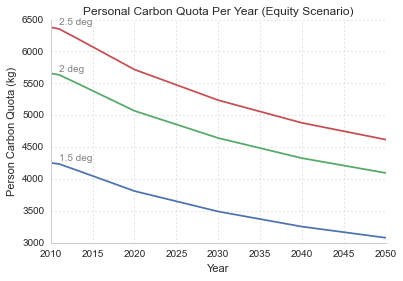

In [36]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

onefive = ((ONEFIVE_DEG_CARBON_BUDGET_KG / 34) / vals)
two = (TWO_DEG_CARBON_BUDGET_KG / 34 / vals)
twofive = (TWOFIVE_DEG_CARBON_BUDGET_KG / 34 / vals)

onefive.plot()
two.plot()
twofive.plot()

# titles & axes
plt.title('Personal Carbon Quota Per Year (Equity Scenario)')
plt.ylabel('Person Carbon Quota (kg)')
plt.xlabel('Year')

# label the pathways
ax.text(2011, onefive[2010] + 40, '1.5 deg', fontsize=10, color='gray')
ax.text(2011, two[2010] + 40, '2 deg', fontsize=10, color='gray')
ax.text(2011, twofive[2010] + 40, '2.5 deg', fontsize=10, color='gray')

pylab.savefig('../images/personal_carbon_quota.png')

### Historical Carbon

In [43]:
# Data: https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:17975
full_ice_core = pd.read_csv(
    '../data/antarctic_ice_cores_revised_800k_yr_co2.csv')

In [44]:
full_ice_core.index = full_ice_core.age_gas_calBP

In [45]:
full_ice_core['age_gas_cal_Greg'] = np.abs(full_ice_core.age_gas_calBP - 1950)

In [46]:
full_ice_core['co2_gt'] = full_ice_core.co2_ppm * 7.76

In [47]:
# full_ice_core.head()

In [48]:
# full_ice_core.sort_values('age_gas_calBP').age_gas_cal_Greg

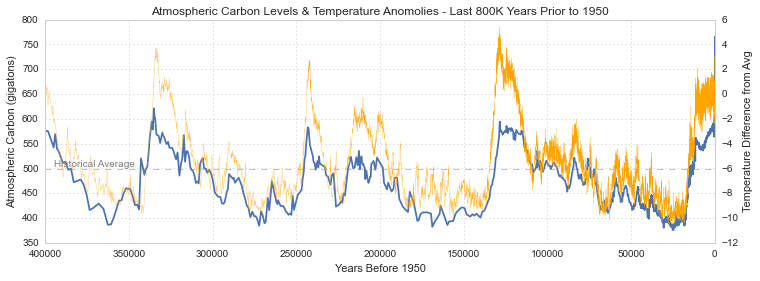

In [292]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)
text_x = 395000

historical_carbon = full_ice_core[full_ice_core.age_gas_calBP <= 400000]
((historical_carbon
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm * 2.08).plot(figsize=(12,4)))
hist_avg = historical_carbon.co2_ppm.mean() * 2.08

plt.title('Atmospheric Carbon Levels & Temperature Anomolies - Last 800K Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (gigatons)')
plt.axhline(hist_avg, color='gray', linewidth=.5, linestyle='--')
ax.text(text_x, hist_avg + 5, 'Historical Average', fontsize=10, color='gray')

ax2 = ax.twinx()
plt.ylabel('Temperature Difference from Avg')
(historic_temp[historic_temp.Age < 400000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.25, color='orange'))
remove_gridlines(ax2)
# sns.despine()

pylab.savefig('../images/historical_carbon_800k.png')

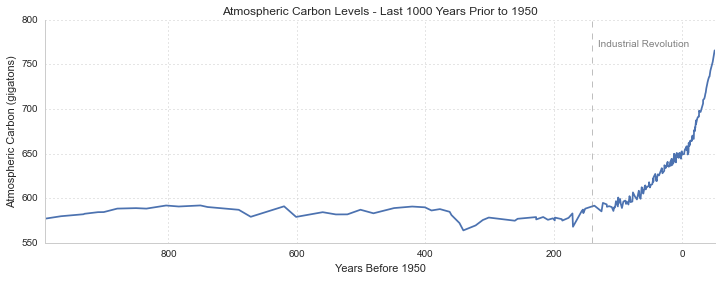

In [297]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

# Plot
((full_ice_core[full_ice_core.age_gas_calBP <= 1000]
     .sort_values('age_gas_calBP', ascending=False)
     .co2_ppm * 2.08).plot(figsize=(12,4)))

# Axix labels and additional glyphs
plt.title('Atmospheric Carbon Levels - Last 1000 Years Prior to 1950')
plt.xlabel('Years Before 1950')
plt.ylabel('Atmospheric Carbon (gigatons)')
ax.text(130, 770, 'Industrial Revolution', fontsize=10, color='gray')
plt.axvline(140, color='gray', linewidth=.5, linestyle='--')

# pylab.savefig('../images/historical_carbon_1k.png')

In [75]:
original = full_ice_core[full_ice_core.age_gas_calBP <= 140].iloc[-1].co2_ppm
current = full_ice_core[full_ice_core.age_gas_calBP <= 140].iloc[0].co2_ppm
difference = current - original
perc_change = difference / original

In [78]:
perc_change

0.29388601764933364

### Historic temperature

In [12]:
historic_temp = pd.read_csv('../data/historic_temp.csv')

In [37]:
historic_temp.index = historic_temp.Age

In [741]:
# historic_temp.sort_index(ascending=False).head()

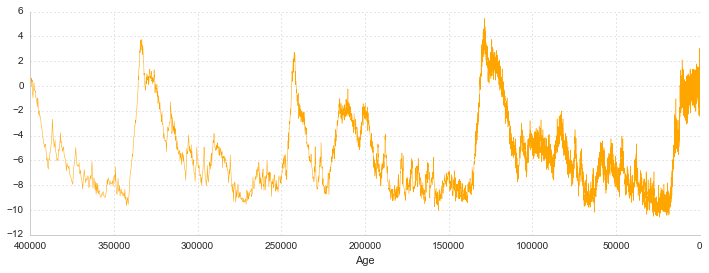

In [54]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

(historic_temp[historic_temp.Age < 400000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.5, color='orange'))

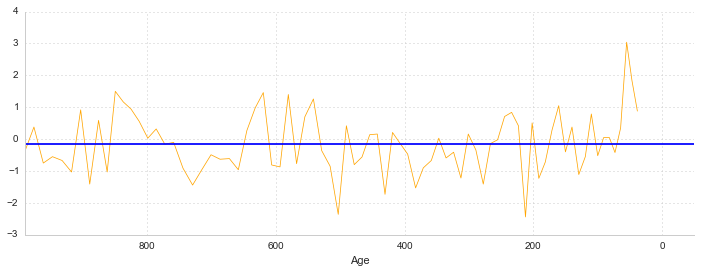

In [283]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

(historic_temp[historic_temp.Age < 1000]
    .sort_index(ascending=False)
    .Temperature.plot(figsize=(12,4), linewidth=.75, color='orange'))

plt.axhline(historic_temp[historic_temp.Age < 1000].Temperature.mean())

### Avg temperature since industrialization

In [302]:
avg_temp = pd.read_csv('../data/GLB.Ts+dSST.csv')

In [304]:
avg_temp.index = avg_temp.Year

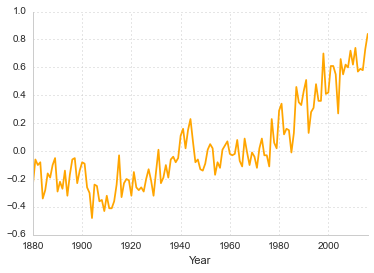

In [342]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)
avg_temp.Jul.plot(color='orange')

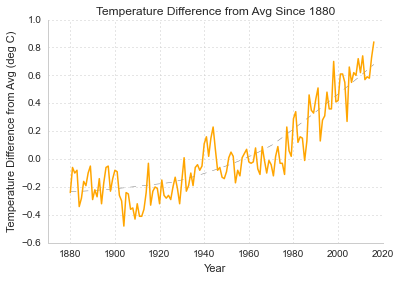

In [373]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

sns.regplot(avg_temp.Year, avg_temp.Jul, 
            lowess=True, color='gray', 
            line_kws={'linewidth': .5, 'linestyle': '--'}, scatter_kws={'s': .1})
avg_temp.Jul.plot(color='orange', linewidth=1.5)
pylab.xlim([1870,2020])
plt.title('Temperature Difference from Avg Since 1880')
plt.xlabel('Year')
plt.ylabel('Temperature Difference from Avg (deg C)')

pylab.savefig('../images/temp_diff_from_avg_1880.png')

In [335]:
j = avg_temp[avg_temp.Year > 1960].Jul

In [336]:
avg_wrm = (j - j.shift(1)).mean()

In [337]:
arr = [0] * 34
arr[0] = avg_temp.Jul.max()

In [338]:
for ix, val in enumerate(arr):
    if ix < len(arr) - 1:
        next_year_val = arr[ix] + (avg_wrm * arr[ix])
        arr[ix+1] = next_year_val

### Anthropogenic Carbon Emissions

In [49]:
anthrocarbon = pd.read_csv('../data/anthro_carbon.csv')

In [50]:
anthrocarbon.index = anthrocarbon.Year

In [738]:
anthrocarbon[anthrocarbon.Year < 1870].Total.sum()

11290.692999999997

In [745]:
anthrocarbon = anthrocarbon[anthrocarbon.Year > 1870]

In [746]:
diff = anthrocarbon.Total - anthrocarbon.Total.shift(1)

In [747]:
sums = anthrocarbon.Total.cumsum()

In [748]:
avg_growth = ((sums - sums.shift(1)) / sums).mean()

In [749]:
current_total = (anthrocarbon.Total / 3.667).cumsum().iloc[-1]

In [750]:
arr = [0] * 87
arr[0] = current_total

In [751]:
for ix, val in enumerate(arr):
    if ix < len(arr) - 1:
        next_year_val = arr[ix] + (avg_growth * arr[ix])
        arr[ix+1] = next_year_val

In [752]:
extrapolated_dates = np.array([2013] * 87) + np.array(range(87))

In [753]:
extrapolated_values = pd.Series(arr, index=extrapolated_dates)

In [52]:
# extrapolated_values[extrapolated_values < 1000000]

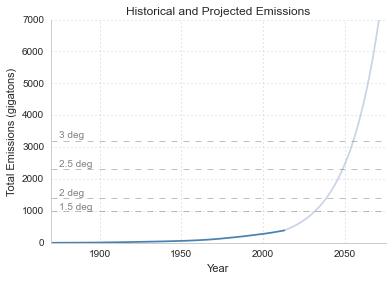

In [758]:
ax = plt.axes()
sns.despine()
modify_gridlines(ax)

plt.axhline(1000, color='gray', linewidth=.5, linestyle='--')
plt.axhline(1400, color='gray', linewidth=.5, linestyle='--')
plt.axhline(2300, color='gray', linewidth=.5, linestyle='--')
plt.axhline(3200, color='gray', linewidth=.5, linestyle='--')

text_x = 1875

ax.text(text_x, 1050, '1.5 deg', fontsize=10, color='gray')
ax.text(text_x, 1500, '2 deg', fontsize=10, color='gray')
ax.text(text_x, 2400, '2.5 deg', fontsize=10, color='gray')
ax.text(text_x, 3300, '3 deg', fontsize=10, color='gray')

(extrapolated_values / 1000).plot(alpha=.3)
(anthrocarbon.Total.cumsum() / 3.667 / 1000).plot(color='steelblue')
pylab.xlim([1870,2075])
pylab.ylim([0,7000])
plt.ylabel('Total Emissions (gigatons)')
plt.title('Historical and Projected Emissions')

# pylab.savefig('../images/historical_and_projected_emissions.png')

#### Negative emissions required to get to zero in 2100

In [759]:
(EMISSIONS_TO_DATE / YEARS_TO_2050) / 1000000000

14.705882352941178

#### Average growth rate of emissions since industrialization

In [53]:
indus = full_ice_core[full_ice_core.age_gas_calBP <= 190]

In [61]:
dppm = ((indus.co2_ppm - indus.co2_ppm.shift(-1)) / indus.co2_ppm) * 100

In [250]:
# fig, axes = plt.subplots(nrows=2, ncols=2);
# grouped_type.get_group('car').carbon.hist(bins=100); axes[0,0];
# grouped_type.get_group('bus').carbon.hist(bins=100); axes[0,1];
# grouped_type.get_group('airplane').carbon.hist(bins=100); axes[1,0];
# grouped_type.get_group('subway').carbon.hist(bins=100); axes[1,1];

In [245]:
# g = sns.FacetGrid(tdf, col="type", size=4, aspect=2, col_wrap=2)
# g.map(sns.distplot, "carbon", bins100);

In [ ]:
# plt.axhline(200, color='red', linewidth=.5)
# plt.axhline(328, color='purple', linewidth=.5)
# plt.axhline(457, color='orange', linewidth=.5)

In [128]:
# sdf = pd.DataFrame(tdf.groupby(lambda d: d.year).carbon.agg('cumsum'))

In [129]:
# sdf['year'] = pd.Series(sdf.index).apply(lambda d: d.year).values

In [130]:
# def lineplot(x, y, **kwargs):
#     ax = plt.gca()
#     data = kwargs.pop("carbon")
#     data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)

In [212]:
# g = sns.FacetGrid(sdf, col="year", size=4, aspect=2, col_wrap=2)
# g.map(plt.plot, "carbon")

In [228]:
# cumulative sum by year
# tdf.groupby(lambda d: d.year).carbon.agg('cumsum').plot()

In [185]:
# carbon per month
# tdf.groupby(lambda d: d.month).carbon.agg('sum').plot(kind='bar', figsize=(18,4))

In [187]:
# sum of carbon per month for each year
# tdf.groupby([lambda d: d.year, lambda d: d.month]).carbon.agg('sum').plot(kind='bar', figsize=(18,4))

In [171]:
# tdf.startDatetime.value_counts()

 - Indeed, despite considerable uncertainties in the exact relationship, modelling has indicated that every metric tonne of CO2 or CO2-equivalent which is emitted by humans results in a roughly linear increase in global atmospheric temperature by approximately 0.0000000000015 degrees Celsius.
 - In general, each degree C of global temperature increase can be expected to produce:
  - 5-10% changes in precipitation across many regions
  - 3-10% increases in the amount of rain falling during the heaviest precipitation events
  - 5-10% changes in streamflow across many river basins
  - 15% decreases in the annually averaged extent of sea ice across the Arctic Ocean, with 25% decreases in the yearly minimum extent in September
  - 5-15% reductions in the yields of crops as currently grown
  - 200-400% increases in the area burned by wildfire in parts of the western United States
 - The components of that budget are: $E_{FF} + E_{LUC} + G_{ATM} - (S_{OCEAN} + S_{LAND})$
 - The budget is balanced if $E_{FF} + E_{LUC} = G_{ATM} + S_{OCEAN} + S_{LAND}$
 - It's estimated that limiting outut from 2000
 - If each person got a fair share of that budget, what would that be?  What is fair share?
 -  The best estimate is that 1,000 gigatonnes of human-emitted carbon emissions leads to about 1.75°C (3.15°F) increase in global average temperature
 - Cumulative carbon emissions to date (2010) are about 500 gigatonnes, and the rate of global emissions is increasing. Based on current understanding, this warming is expected to be nearly irreversible for more than 1,000 years.
 - Many aspects of climate are expected to change in a linear fashion as temperatures rise